In [1]:
import sys

import sklearn
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
pd.options.display.max_rows = 10
train = pd.read_csv('./train.csv', index_col='id')
train

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL
...,...,...
id17718,"I could have fancied, while I looked at it, th...",EAP
id08973,The lids clenched themselves together as if in...,EAP
id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP


In [3]:
# Да си заредим библиотеките

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [4]:
# Да започнем с CountVectorizer и логистична регресия

pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('logreg', LogisticRegression())
])

print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3))
print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3, scoring='neg_log_loss'))

[ 0.81449142  0.81673307  0.81348659]
[-0.47678328 -0.47558895 -0.47131481]


In [5]:
# Това дава някакъв резултат който да се стремим да подобрим.
# Ще започна с добавяне на feature-и сходни на онези от лекцията. Например:
# бр. stopwords, бр. препинателни знаци, бр. главни букви, бр.уникални думи

# Само че за разлика от на лекцията, ще разделя всеки от тези feature-и на броя думи
# За да получа параметри които не зависят строго от дължината на текста.
# Т.е. ще получа честота на stopwords, честота на препинателнни знаци и т.н. което е доста по-смислено.

# За удобство тук ще създам функция която да прави това.

import string
import nltk
#nltk.download('stopwords')

def add_features(data):
    newdata = data.copy()
    
    # бр. думи в текста
    newdata['words'] = newdata.text.apply(lambda s: len(str(s).split()))

    # честота уникални думи
    newdata['unique_words'] = newdata.text.apply(lambda s: len(set(str(s).split()))) / newdata.words

    # честота главни букви
    newdata['capital_letters'] = newdata.text.apply(lambda s: sum([str.isupper(c) for c in str(s)])) / newdata.words

    # средна дължина на дума
    newdata['average_word_length'] = newdata.text.apply(lambda s: np.mean([len(w) for w in str(s).split()]))

    # честота на препинателни знаци
    newdata["punctuation"] = newdata.text.apply(lambda s: sum([c in string.punctuation for c in str(s)])) / newdata.words

    # честота на stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    newdata['stop_words'] = newdata.text.apply(lambda s: sum(w in stopwords for w in str(s).split())) / newdata.words
    
    newdata = newdata.drop('words', axis=1)
    return newdata

modified = add_features(train)
modified

,text,author,unique_words,capital_letters,average_word_length,punctuation,stop_words
id,,,,,,,
id26305,"This process, however, afforded me no means of...",EAP,0.853659,0.073171,4.658537,0.170732,0.390244
id17569,It never once occurred to me that the fumbling...,HPL,1.000000,0.071429,4.142857,0.071429,0.500000
id11008,"In his left hand was a gold snuff box, from wh...",EAP,0.888889,0.027778,4.583333,0.138889,0.416667
id27763,How lovely is spring As we looked from Windsor...,MWS,0.941176,0.117647,5.088235,0.117647,0.323529
id12958,"Finding nothing else, not even gold, the Super...",HPL,0.925926,0.074074,5.481481,0.148148,0.407407
...,...,...,...,...,...,...,...
id17718,"I could have fancied, while I looked at it, th...",EAP,0.950000,0.100000,4.450000,0.150000,0.450000
id08973,The lids clenched themselves together as if in...,EAP,1.000000,0.100000,4.600000,0.100000,0.500000
id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP,1.000000,0.153846,4.307692,0.153846,0.307692


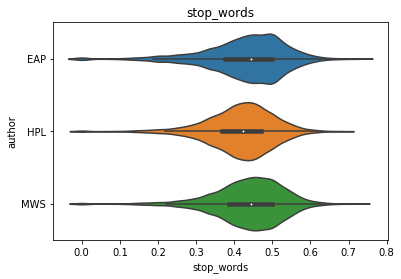

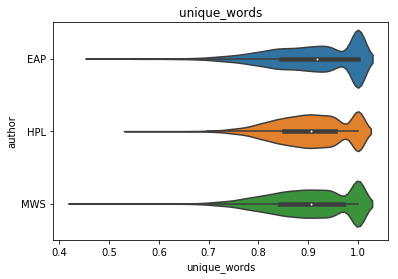

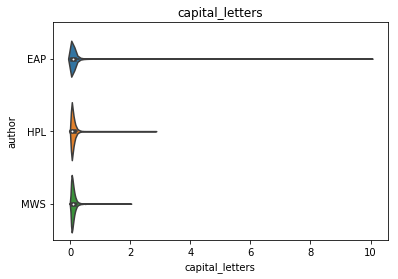

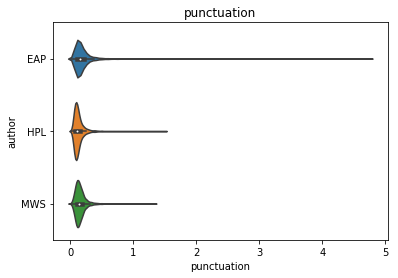

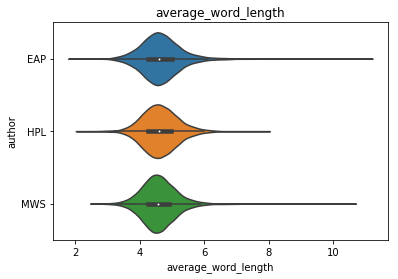

In [6]:
# Да видим дали тези feature-и значат нещо повече от тези на лекцията
# За целта разглеждаме дистрибуциите

feature_names = list(set(modified.columns) - {'text', 'author'})
for feature in feature_names:
    plt.figure()
    sns.violinplot(x=feature, y="author", data=modified)
    plt.title(feature);

In [7]:
# Излгежда сякаш в punctuation и capital_letters може да има някаква информация
# Нека ги нормираме използвайки StandartScaler.
# Освен това, unique_words и average_word_length изглеждат безполезни за това ще ги махна

from sklearn.preprocessing import scale

modified = modified.drop(['unique_words', 'average_word_length'], axis=1)
modified['capital_letters'] = scale(modified['capital_letters'])
modified['punctuation'] = scale(modified['punctuation'])
modified

,text,author,capital_letters,punctuation,stop_words
id,,,,,
id26305,"This process, however, afforded me no means of...",EAP,-0.232285,0.096348,0.390244
id17569,It never once occurred to me that the fumbling...,HPL,-0.244266,-0.731359,0.500000
id11008,"In his left hand was a gold snuff box, from wh...",EAP,-0.544454,-0.169067,0.416667
id27763,How lovely is spring As we looked from Windsor...,MWS,0.073580,-0.346121,0.323529
id12958,"Finding nothing else, not even gold, the Super...",HPL,-0.226073,-0.091889,0.407407
...,...,...,...,...,...
id17718,"I could have fancied, while I looked at it, th...",EAP,-0.047780,-0.076454,0.450000
id08973,The lids clenched themselves together as if in...,EAP,-0.047780,-0.493212,0.500000
id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP,0.322522,-0.044395,0.307692


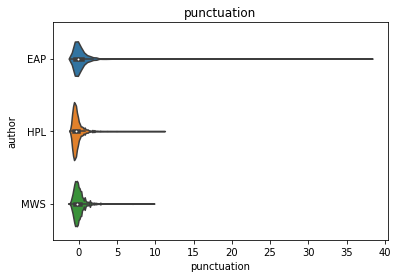

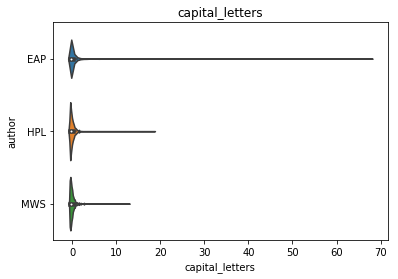

In [8]:
# Да видим пак дистрибуциите

plt.figure()
sns.violinplot(x='punctuation', y="author", data=modified, bw=.05)
plt.title('punctuation');

plt.figure()
sns.violinplot(x='capital_letters', y="author", data=modified, bw=.05)
plt.title('capital_letters');

In [10]:
# Не изглежда обещаващо, но все пак да пробваме с няколко алгоритъма

from sklearn.ensemble import RandomForestClassifier

x = modified.drop(['text', 'author'], axis=1)
y = modified.author
print('logreg:', cross_val_score(LogisticRegression(), x, y, cv=3, n_jobs=3))
print('randfor:', cross_val_score(RandomForestClassifier(), x, y, cv=3, n_jobs=3))
print('svc:', cross_val_score(LinearSVC(), x, y, cv=3, n_jobs=3))

logreg: [ 0.45664828  0.4501992   0.45302682]
randfor: [ 0.43688725  0.43334355  0.42850575]
svc: [ 0.45327819  0.44943304  0.45164751]


In [15]:
# Резултатите не са добри, но все пак са по-добри от тези на лекцията :D
# Да проверим все пак и резултатите с колоните които махнах

modified = add_features(train)
modified['capital_letters'] = scale(modified['capital_letters'])
modified['punctuation'] = scale(modified['punctuation'])

x = modified.drop(['text', 'author'], axis=1)
y = modified.author
print('logreg:', cross_val_score(LogisticRegression(), x, y, cv=3, n_jobs=3))
print('randfor:', cross_val_score(RandomForestClassifier(), x, y, cv=3, n_jobs=3))
print('svc:', cross_val_score(LinearSVC(), x, y, cv=3, n_jobs=3))

logreg: [ 0.453125    0.44713454  0.44950192]
randfor: [ 0.42953431  0.43855348  0.42574713]
svc: [ 0.45266544  0.44636837  0.45057471]


In [72]:
# Без излишните данни беше по-добре както и предполагах.
# Тези колони ще ги добавя след прилагането на CountVectorizer с надеждадата да внесат дори и малка промяна
# За целта ще декларирам трансформатор който да добавя характеристиките които разглеждах до сега

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

class NumericFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, x, y=None):
        return self

    def transform(self, data):
        newdata = pd.DataFrame();
        newdata['text'] = data
    
        # бр. думи в текста
        newdata['words'] = newdata.text.apply(lambda s: len(str(s).split()))

        # честота главни букви
        newdata['capital_letters'] = newdata.text.apply(lambda s: sum([str.isupper(c) for c in str(s)])) / newdata.words

        # честота на препинателни знаци
        newdata["punctuation"] = newdata.text.apply(lambda s: sum([c in string.punctuation for c in str(s)])) / newdata.words

        # честота на stopwords
        stopwords = nltk.corpus.stopwords.words('english')
        newdata['stop_words'] = newdata.text.apply(lambda s: sum(w in stopwords for w in str(s).split())) / newdata.words

        newdata = newdata.drop(['words', 'text'], axis=1)
        newdata['capital_letters'] = scale(newdata['capital_letters'])
        newdata['punctuation'] = scale(newdata['punctuation'])
        return newdata
    

nf = NumericFeatures()
nf.transform(train.text)

,capital_letters,punctuation,stop_words
id,,,
id26305,-0.232285,0.096348,0.390244
id17569,-0.244266,-0.731359,0.500000
id11008,-0.544454,-0.169067,0.416667
id27763,0.073580,-0.346121,0.323529
id12958,-0.226073,-0.091889,0.407407
...,...,...,...
id17718,-0.047780,-0.076454,0.450000
id08973,-0.047780,-0.493212,0.500000
id05267,0.322522,-0.044395,0.307692


In [76]:
# Правя FeatureUnion на NumericFeatures и CountVectorizer и го слагам в Pipeline със логистичната регресия
# Да видим дали е по-добре

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('numeric', NumericFeatures()),
        ('vectorizer', CountVectorizer())
    ])),
    ('clf', LogisticRegression())
])

print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3))
print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3, scoring='neg_log_loss'))

# резултати без NumericFeatures
# [ 0.81449142  0.81673307  0.81348659]
# [-0.47678328 -0.47558895 -0.47131481]

[ 0.81770833  0.8164266   0.81501916]
[-0.47257525 -0.47170967 -0.47109058]


In [27]:
# Супер има подобрение (макар и минимално)
# Сега ще пробвам с различни алгоритми и различни хиперпараметри
# За целта ще ползвам функцията report() от лекцията и ще модифицирам функцията random_search()

def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [80]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss

def random_search(pipeline, params):
    search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                scoring='neg_log_loss',
                                n_iter=20, cv=3, n_jobs=4)

    search.fit(train.text, train.author)
    report(search.cv_results_)

In [81]:
# Да пробваме първо с логистична регресия
stopwords = nltk.corpus.stopwords.words('english')
params_vectorizer = {"features__vectorizer__ngram_range": [(1,1), (1,2)],
                     "features__vectorizer__analyzer": ['word'],
                     "features__vectorizer__max_df":[1.0, 0.9, 0.8, 0.7, 0.6, 0.5],
                     "features__vectorizer__min_df":[2, 3, 5, 10],
                     "features__vectorizer__lowercase": [False, True],
                     "features__vectorizer__stop_words": [None, stopwords]}

params = {"clf__C": [0.1, 0.3, 1, 3, 10]}
params.update(params_vectorizer)

random_search(pipeline, params)

Model with rank: 1
Mean validation score: -0.473 (std: 0.002)
Parameters: {'features__vectorizer__max_df': 0.5, 'features__vectorizer__analyzer': 'word', 'clf__C': 1, 'features__vectorizer__lowercase': False, 'features__vectorizer__min_df': 2, 'features__vectorizer__ngram_range': (1, 1), 'features__vectorizer__stop_words': None}

Model with rank: 2
Mean validation score: -0.476 (std: 0.003)
Parameters: {'features__vectorizer__max_df': 0.5, 'features__vectorizer__analyzer': 'word', 'clf__C': 1, 'features__vectorizer__lowercase': True, 'features__vectorizer__min_df': 3, 'features__vectorizer__ngram_range': (1, 2), 'features__vectorizer__stop_words': None}

Model with rank: 3
Mean validation score: -0.487 (std: 0.002)
Parameters: {'features__vectorizer__max_df': 0.9, 'features__vectorizer__analyzer': 'word', 'clf__C': 1, 'features__vectorizer__lowercase': True, 'features__vectorizer__min_df': 5, 'features__vectorizer__ngram_range': (1, 2), 'features__vectorizer__stop_words': None}

Model 

In [83]:
# Да пробваме с Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('numeric', NumericFeatures()),
        ('vectorizer', TfidfVectorizer())
    ])),
    ('clf', LogisticRegression())
])

random_search(pipeline, params)

Model with rank: 1
Mean validation score: -0.470 (std: 0.006)
Parameters: {'features__vectorizer__max_df': 0.5, 'features__vectorizer__analyzer': 'word', 'clf__C': 10, 'features__vectorizer__lowercase': False, 'features__vectorizer__min_df': 2, 'features__vectorizer__ngram_range': (1, 3), 'features__vectorizer__stop_words': None}

Model with rank: 2
Mean validation score: -0.480 (std: 0.006)
Parameters: {'features__vectorizer__max_df': 0.9, 'features__vectorizer__analyzer': 'word', 'clf__C': 10, 'features__vectorizer__lowercase': True, 'features__vectorizer__min_df': 5, 'features__vectorizer__ngram_range': (1, 2), 'features__vectorizer__stop_words': None}

Model with rank: 3
Mean validation score: -0.480 (std: 0.007)
Parameters: {'features__vectorizer__max_df': 0.6, 'features__vectorizer__analyzer': 'word', 'clf__C': 10, 'features__vectorizer__lowercase': True, 'features__vectorizer__min_df': 5, 'features__vectorizer__ngram_range': (1, 3), 'features__vectorizer__stop_words': None}

Mod

In [84]:
# С Тfdif получавам по-добри резултати
# Да пробваме и с алгоритъма MultinomialNB

from sklearn.naive_bayes import MultinomialNB

params = {"clf__alpha": [0.1, 0.3, 1, 3, 10]}
params.update(params_vectorizer)

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('numeric', NumericFeatures()),
        ('vectorizer', TfidfVectorizer())
    ])),
    ('clf', MultinomialNB())
])

random_search(pipeline, params)

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/dist-packages/ipykernel_launcher.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
/usr/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7fb9c519d660, file "/...3.5/dist-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/python3.5/dist-packages/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/dist-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/dist-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7fb9c519d660, file "/...3.5/dist-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/python3.5/dist-packages/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/dist-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '# С Тfdif получавам по-добри резултати\n# Да проб...tinomialNB())\n])\n\nrandom_search(pipeline, params)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 11, 25, 20, 41, 52, 694907, tzinfo=tzutc()), 'msg_id': '6DF86726421D44B6B8F2D3145588F9AC', 'msg_type': 'execute_request', 'session': 'ED232BBC98DB402E81B31517D6BA7007', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '6DF86726421D44B6B8F2D3145588F9AC', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'ED232BBC98DB402E81B31517D6BA7007']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '# С Тfdif получавам по-добри резултати\n# Да проб...tinomialNB())\n])\n\nrandom_search(pipeline, params)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 11, 25, 20, 41, 52, 694907, tzinfo=tzutc()), 'msg_id': '6DF86726421D44B6B8F2D3145588F9AC', 'msg_type': 'execute_request', 'session': 'ED232BBC98DB402E81B31517D6BA7007', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '6DF86726421D44B6B8F2D3145588F9AC', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'ED232BBC98DB402E81B31517D6BA7007'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '# С Тfdif получавам по-добри резултати\n# Да проб...tinomialNB())\n])\n\nrandom_search(pipeline, params)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 11, 25, 20, 41, 52, 694907, tzinfo=tzutc()), 'msg_id': '6DF86726421D44B6B8F2D3145588F9AC', 'msg_type': 'execute_request', 'session': 'ED232BBC98DB402E81B31517D6BA7007', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '6DF86726421D44B6B8F2D3145588F9AC', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='# С Тfdif получавам по-добри резултати\n# Да проб...tinomialNB())\n])\n\nrandom_search(pipeline, params)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '# С Тfdif получавам по-добри резултати\n# Да проб...tinomialNB())\n])\n\nrandom_search(pipeline, params)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('# С Тfdif получавам по-добри резултати\n# Да проб...tinomialNB())\n])\n\nrandom_search(pipeline, params)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('# С Тfdif получавам по-добри резултати\n# Да проб...tinomialNB())\n])\n\nrandom_search(pipeline, params)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# С Тfdif получавам по-добри резултати\n# Да проб...tinomialNB())\n])\n\nrandom_search(pipeline, params)', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-84-08dac5ce39e1>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7fb99b80ad68, executi..._before_exec=None error_in_exec=None result=None>)
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])
   2855                 code = compiler(mod, cell_name, "single")
-> 2856                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7fb9967f5a50, file "<ipython-input-84-08dac5ce39e1>", line 17>
        result = <ExecutionResult object at 7fb99b80ad68, executi..._before_exec=None error_in_exec=None result=None>
   2857                     return True
   2858 
   2859             # Flush softspace
   2860             if softspace(sys.stdout, 0):

...........................................................................
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7fb9967f5a50, file "<ipython-input-84-08dac5ce39e1>", line 17>, result=<ExecutionResult object at 7fb99b80ad68, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7fb9967f5a50, file "<ipython-input-84-08dac5ce39e1>", line 17>
        self.user_global_ns = {'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'FeatureUnion': <class 'sklearn.pipeline.FeatureUnion'>, 'In': ['', "import sys\n\nimport sklearn\nimport pandas as pd\ni..._ipython().run_line_magic('matplotlib', 'inline')", "pd.options.display.max_rows = 10\ntrain = pd.read_csv('./train.csv', index_col='id')\ntrain", '# Да си заредим библиотеките\n\nfrom sklearn.pipel...om sklearn.linear_model import LogisticRegression', "# Да започнем с CountVectorizer и логистична рег....author, cv=3, n_jobs=3, scoring='neg_log_loss'))", '# Това дава някакъв резултат който да се стремим... newdata\n\nmodified = add_features(train)\nmodified', '# Да видим дали тези feature-и значат нещо повеч...="author", data=modified)\n    plt.title(feature);', "# Излгежда сякаш в punctuation и capital_letters...ation'] = scale(modified['punctuation'])\nmodified", "# Да видим пак дистрибуциите\n\nplt.figure()\nsns.v...a=modified, bw=.05)\nplt.title('capital_letters');", '# Не изглежда обещаващо, но все пак да пробваме ...ross_val_score(LinerSVC(), x, y, cv=3, n_jobs=3))', '# Не изглежда обещаващо, но все пак да пробваме ...oss_val_score(LinearSVC(), x, y, cv=3, n_jobs=3))', '# Резултатите не са добри, но все пак са по-добр...oss_val_score(LinearSVC(), x, y, cv=3, n_jobs=3))', '# Само че забравих да скалирам данните\n\nmodified...oss_val_score(LinearSVC(), x, y, cv=3, n_jobs=3))', '# Резултатите не са добри, но все пак са по-добр...oss_val_score(LinearSVC(), x, y, cv=3, n_jobs=3))', '# Резултатите не са добри, но все пак са по-добр...oss_val_score(LinearSVC(), x, y, cv=3, n_jobs=3))', '# Резултатите не са добри, но все пак са по-добр...oss_val_score(LinearSVC(), x, y, cv=3, n_jobs=3))', "# Без излишните данни беше по-добре както и пред...le(newdata['punctuation'])\n        return newdata", '# Без излишните данни беше по-добре както и пред... = NumericFeatures()\nnf.fit_transform(train.text)', '# Без излишните данни беше по-добре както и пред...\n\nnf = NumericFeatures()\nnf.transform(train.text)', '# Без излишните данни беше по-добре както и пред...wdata\n\nnf = NumericFeatures()\nnf.transform(train)', ...], 'ItemSelector': <class '__main__.ItemSelector'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'NumericFeatures': <class '__main__.NumericFeatures'>, 'Out': {2:                                                 ...lder, and it ...    HPL

[19579 rows x 2 columns], 5:                                                 ... 
id00393    0.590909  

[19579 rows x 7 columns], 7:                                                 ...-0.568986    0.590909  

[19579 rows x 5 columns], 19:                                                 ...-0.568986    0.590909  

[19579 rows x 5 columns], 20: id
id26305    This process, however, afforded me...d it ...
Name: text, Length: 19579, dtype: object, 22:          capital_letters  punctuation  stop_word...  -0.568986    0.590909

[19579 rows x 3 columns], 23: <19579x25071 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, 25: array([ 0.81770833,  0.8164266 ,  0.81501916]), 35:          capital_letters  punctuation  stop_word...  -0.568986    0.590909

[19579 rows x 3 columns], 37:          capital_letters  punctuation  stop_word...  -0.568986    0.590909

[19579 rows x 3 columns], ...}, ...}
        self.user_ns = {'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'FeatureUnion': <class 'sklearn.pipeline.FeatureUnion'>, 'In': ['', "import sys\n\nimport sklearn\nimport pandas as pd\ni..._ipython().run_line_magic('matplotlib', 'inline')", "pd.options.display.max_rows = 10\ntrain = pd.read_csv('./train.csv', index_col='id')\ntrain", '# Да си заредим библиотеките\n\nfrom sklearn.pipel...om sklearn.linear_model import LogisticRegression', "# Да започнем с CountVectorizer и логистична рег....author, cv=3, n_jobs=3, scoring='neg_log_loss'))", '# Това дава някакъв резултат който да се стремим... newdata\n\nmodified = add_features(train)\nmodified', '# Да видим дали тези feature-и значат нещо повеч...="author", data=modified)\n    plt.title(feature);', "# Излгежда сякаш в punctuation и capital_letters...ation'] = scale(modified['punctuation'])\nmodified", "# Да видим пак дистрибуциите\n\nplt.figure()\nsns.v...a=modified, bw=.05)\nplt.title('capital_letters');", '# Не изглежда обещаващо, но все пак да пробваме ...ross_val_score(LinerSVC(), x, y, cv=3, n_jobs=3))', '# Не изглежда обещаващо, но все пак да пробваме ...oss_val_score(LinearSVC(), x, y, cv=3, n_jobs=3))', '# Резултатите не са добри, но все пак са по-добр...oss_val_score(LinearSVC(), x, y, cv=3, n_jobs=3))', '# Само че забравих да скалирам данните\n\nmodified...oss_val_score(LinearSVC(), x, y, cv=3, n_jobs=3))', '# Резултатите не са добри, но все пак са по-добр...oss_val_score(LinearSVC(), x, y, cv=3, n_jobs=3))', '# Резултатите не са добри, но все пак са по-добр...oss_val_score(LinearSVC(), x, y, cv=3, n_jobs=3))', '# Резултатите не са добри, но все пак са по-добр...oss_val_score(LinearSVC(), x, y, cv=3, n_jobs=3))', "# Без излишните данни беше по-добре както и пред...le(newdata['punctuation'])\n        return newdata", '# Без излишните данни беше по-добре както и пред... = NumericFeatures()\nnf.fit_transform(train.text)', '# Без излишните данни беше по-добре както и пред...\n\nnf = NumericFeatures()\nnf.transform(train.text)', '# Без излишните данни беше по-добре както и пред...wdata\n\nnf = NumericFeatures()\nnf.transform(train)', ...], 'ItemSelector': <class '__main__.ItemSelector'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'NumericFeatures': <class '__main__.NumericFeatures'>, 'Out': {2:                                                 ...lder, and it ...    HPL

[19579 rows x 2 columns], 5:                                                 ... 
id00393    0.590909  

[19579 rows x 7 columns], 7:                                                 ...-0.568986    0.590909  

[19579 rows x 5 columns], 19:                                                 ...-0.568986    0.590909  

[19579 rows x 5 columns], 20: id
id26305    This process, however, afforded me...d it ...
Name: text, Length: 19579, dtype: object, 22:          capital_letters  punctuation  stop_word...  -0.568986    0.590909

[19579 rows x 3 columns], 23: <19579x25071 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, 25: array([ 0.81770833,  0.8164266 ,  0.81501916]), 35:          capital_letters  punctuation  stop_word...  -0.568986    0.590909

[19579 rows x 3 columns], 37:          capital_letters  punctuation  stop_word...  -0.568986    0.590909

[19579 rows x 3 columns], ...}, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/home/ivo/fmi/kaggle/spooky/<ipython-input-84-08dac5ce39e1> in <module>()
     12         ('vectorizer', TfidfVectorizer())
     13     ])),
     14     ('clf', MultinomialNB())
     15 ])
     16 
---> 17 random_search(pipeline, params)

...........................................................................
/home/ivo/fmi/kaggle/spooky/<ipython-input-80-c60216dbf92e> in random_search(pipeline=Pipeline(memory=None,
     steps=[('features', F...B(alpha=1.0, class_prior=None, fit_prior=True))]), params={'clf__alpha': [0.1, 0.3, 1, 3, 10], 'features__vectorizer__analyzer': ['word'], 'features__vectorizer__lowercase': [False, True], 'features__vectorizer__max_df': [1.0, 0.9, 0.8, 0.7, 0.6, 0.5], 'features__vectorizer__min_df': [2, 3, 5, 10], 'features__vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)], 'features__vectorizer__stop_words': [None, ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', ...]]})
      4 def random_search(pipeline, params):
      5     search = RandomizedSearchCV(pipeline, param_distributions=params, 
      6                                 scoring='neg_log_loss',
      7                                 n_iter=20, cv=3, n_jobs=4)
      8 
----> 9     search.fit(train.text, train.author)
     10     report(search.cv_results_)

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py in fit(self=RandomizedSearchCV(cv=3, error_score='raise',
  ..._score='warn', scoring='neg_log_loss', verbose=0), X=id
id26305    This process, however, afforded me...d it ...
Name: text, Length: 19579, dtype: object, y=id
id26305    EAP
id17569    HPL
id11008    EAP
...   HPL
Name: author, Length: 19579, dtype: object, groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=3, random_state=None, shuffle=False)>
        X = id
id26305    This process, however, afforded me...d it ...
Name: text, Length: 19579, dtype: object
        y = id
id26305    EAP
id17569    HPL
id11008    EAP
...   HPL
Name: author, Length: 19579, dtype: object
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sat Nov 25 22:41:57 2017
PID: 19589                                   Python 3.5.2: /usr/bin/python3
...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('features', F...NB(alpha=10, class_prior=None, fit_prior=True))]), id
id26305    This process, however, afforded me...d it ...
Name: text, Length: 19579, dtype: object, id
id26305    EAP
id17569    HPL
id11008    EAP
...   HPL
Name: author, Length: 19579, dtype: object, {'score': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}, array([ 6475,  6476,  6478, ..., 19576, 19577, 19578]), array([   0,    1,    2, ..., 6604, 6605, 6606]), 0, {'clf__alpha': 10, 'features__vectorizer__analyzer': 'word', 'features__vectorizer__lowercase': False, 'features__vectorizer__max_df': 0.8, 'features__vectorizer__min_df': 10, 'features__vectorizer__ngram_range': (1, 3), 'features__vectorizer__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', ...]}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('features', F...NB(alpha=10, class_prior=None, fit_prior=True))]), id
id26305    This process, however, afforded me...d it ...
Name: text, Length: 19579, dtype: object, id
id26305    EAP
id17569    HPL
id11008    EAP
...   HPL
Name: author, Length: 19579, dtype: object, {'score': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}, array([ 6475,  6476,  6478, ..., 19576, 19577, 19578]), array([   0,    1,    2, ..., 6604, 6605, 6606]), 0, {'clf__alpha': 10, 'features__vectorizer__analyzer': 'word', 'features__vectorizer__lowercase': False, 'features__vectorizer__max_df': 0.8, 'features__vectorizer__min_df': 10, 'features__vectorizer__ngram_range': (1, 3), 'features__vectorizer__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', ...]})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('features', F...NB(alpha=10, class_prior=None, fit_prior=True))]), X=id
id26305    This process, however, afforded me...d it ...
Name: text, Length: 19579, dtype: object, y=id
id26305    EAP
id17569    HPL
id11008    EAP
...   HPL
Name: author, Length: 19579, dtype: object, scorer={'score': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}, train=array([ 6475,  6476,  6478, ..., 19576, 19577, 19578]), test=array([   0,    1,    2, ..., 6604, 6605, 6606]), verbose=0, parameters={'clf__alpha': 10, 'features__vectorizer__analyzer': 'word', 'features__vectorizer__lowercase': False, 'features__vectorizer__max_df': 0.8, 'features__vectorizer__min_df': 10, 'features__vectorizer__ngram_range': (1, 3), 'features__vectorizer__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', ...]}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method Pipeline.fit of Pipeline(memory=No...B(alpha=10, class_prior=None, fit_prior=True))])>
        X_train = id
id15739    Its close resemblance to the medic...d it ...
Name: text, Length: 13051, dtype: object
        y_train = id
id15739    EAP
id19588    EAP
id11059    EAP
...   HPL
Name: author, Length: 13051, dtype: object
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/pipeline.py in fit(self=Pipeline(memory=None,
     steps=[('features', F...NB(alpha=10, class_prior=None, fit_prior=True))]), X=id
id15739    Its close resemblance to the medic...d it ...
Name: text, Length: 13051, dtype: object, y=id
id15739    EAP
id19588    EAP
id11059    EAP
...   HPL
Name: author, Length: 13051, dtype: object, **fit_params={})
    245         self : Pipeline
    246             This estimator
    247         """
    248         Xt, fit_params = self._fit(X, y, **fit_params)
    249         if self._final_estimator is not None:
--> 250             self._final_estimator.fit(Xt, y, **fit_params)
        self._final_estimator.fit = <bound method BaseDiscreteNB.fit of MultinomialNB(alpha=10, class_prior=None, fit_prior=True)>
        Xt = <13051x3613 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>
        y = id
id15739    EAP
id19588    EAP
id11059    EAP
...   HPL
Name: author, Length: 13051, dtype: object
        fit_params = {}
    251         return self
    252 
    253     def fit_transform(self, X, y=None, **fit_params):
    254         """Fit the model and transform with the final estimator

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/naive_bayes.py in fit(self=MultinomialNB(alpha=10, class_prior=None, fit_prior=True), X=<13051x3613 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, y=array(['EAP', 'EAP', 'EAP', ..., 'EAP', 'EAP', 'HPL'], dtype=object), sample_weight=None)
    599         # and feature log probas
    600         n_effective_classes = Y.shape[1]
    601         self.class_count_ = np.zeros(n_effective_classes, dtype=np.float64)
    602         self.feature_count_ = np.zeros((n_effective_classes, n_features),
    603                                        dtype=np.float64)
--> 604         self._count(X, Y)
        self._count = <bound method MultinomialNB._count of MultinomialNB(alpha=10, class_prior=None, fit_prior=True)>
        X = <13051x3613 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>
        Y = array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
...
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.]])
    605         alpha = self._check_alpha()
    606         self._update_feature_log_prob(alpha)
    607         self._update_class_log_prior(class_prior=class_prior)
    608         return self

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/naive_bayes.py in _count(self=MultinomialNB(alpha=10, class_prior=None, fit_prior=True), X=<13051x3613 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, Y=array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
...
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.]]))
    703         self.class_prior = class_prior
    704 
    705     def _count(self, X, Y):
    706         """Count and smooth feature occurrences."""
    707         if np.any((X.data if issparse(X) else X) < 0):
--> 708             raise ValueError("Input X must be non-negative")
    709         self.feature_count_ += safe_sparse_dot(Y.T, X)
    710         self.class_count_ += Y.sum(axis=0)
    711 
    712     def _update_feature_log_prob(self, alpha):

ValueError: Input X must be non-negative
___________________________________________________________________________

In [85]:
# Греда... multinomialNB иска положителни числа за аргументи.
# От NumericFeatures ще махна стандартното скалиране

class NumericFeatures2(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, x, y=None):
        return self

    def transform(self, data):
        newdata = pd.DataFrame();
        newdata['text'] = data
    
        # бр. думи в текста
        newdata['words'] = newdata.text.apply(lambda s: len(str(s).split()))

        # честота главни букви
        newdata['capital_letters'] = newdata.text.apply(lambda s: sum([str.isupper(c) for c in str(s)])) / newdata.words

        # честота на препинателни знаци
        newdata["punctuation"] = newdata.text.apply(lambda s: sum([c in string.punctuation for c in str(s)])) / newdata.words

        # честота на stopwords
        stopwords = nltk.corpus.stopwords.words('english')
        newdata['stop_words'] = newdata.text.apply(lambda s: sum(w in stopwords for w in str(s).split())) / newdata.words

        newdata = newdata.drop(['words', 'text'], axis=1)
        # newdata['capital_letters'] = scale(newdata['capital_letters'])
        # newdata['punctuation'] = scale(newdata['punctuation'])
        return newdata

In [87]:
params = {"clf__alpha": [0.1, 0.3, 1, 3, 10]}
params.update(params_vectorizer)

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('numeric', NumericFeatures2()),
        ('vectorizer', TfidfVectorizer())
    ])),
    ('clf', MultinomialNB())
])

random_search(pipeline, params)

Model with rank: 1
Mean validation score: -0.451 (std: 0.002)
Parameters: {'features__vectorizer__max_df': 0.7, 'features__vectorizer__analyzer': 'word', 'features__vectorizer__lowercase': True, 'features__vectorizer__min_df': 2, 'features__vectorizer__ngram_range': (1, 2), 'features__vectorizer__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 

In [88]:
# Получих резултат от -0.451 ще попроменя малко параметрите и ще видя дали ще стигна до подобрение
# Например виждам че по добрите резултати имат сравнително малко alpha

params_vectorizer = {"features__vectorizer__ngram_range": [(1,1), (1,2)],
                     "features__vectorizer__analyzer": ['word'],
                     "features__vectorizer__max_df":[0.9, 0.8, 0.7, 0.6, 0.5],
                     "features__vectorizer__min_df":[1, 2, 3],
                     "features__vectorizer__lowercase": [False, True],
                     "features__vectorizer__stop_words": [None, stopwords]}

params = {"clf__alpha": [0.01, 0.03, 0.1, 0.3, 1]}
params.update(params_vectorizer)

random_search(pipeline, params)

Model with rank: 1
Mean validation score: -0.385 (std: 0.002)
Parameters: {'features__vectorizer__max_df': 0.7, 'features__vectorizer__analyzer': 'word', 'features__vectorizer__lowercase': True, 'features__vectorizer__min_df': 1, 'features__vectorizer__ngram_range': (1, 2), 'features__vectorizer__stop_words': None, 'clf__alpha': 0.03}

Model with rank: 2
Mean validation score: -0.399 (std: 0.004)
Parameters: {'features__vectorizer__max_df': 0.9, 'features__vectorizer__analyzer': 'word', 'features__vectorizer__lowercase': False, 'features__vectorizer__min_df': 1, 'features__vectorizer__ngram_range': (1, 2), 'features__vectorizer__stop_words': None, 'clf__alpha': 0.01}

Model with rank: 3
Mean validation score: -0.401 (std: 0.004)
Parameters: {'features__vectorizer__max_df': 0.8, 'features__vectorizer__analyzer': 'word', 'features__vectorizer__lowercase': True, 'features__vectorizer__min_df': 1, 'features__vectorizer__ngram_range': (1, 2), 'features__vectorizer__stop_words': None, 'clf__

In [91]:
# Намерихме добро попадение този път
# Ще събмитна с първия модел с резултат -0.385 а именно
# {'features__vectorizer__max_df': 0.7, 'features__vectorizer__analyzer': 'word', 'features__vectorizer__lowercase': True, 'features__vectorizer__min_df': 1, 'features__vectorizer__ngram_range': (1, 2), 'features__vectorizer__stop_words': None, 'clf__alpha': 0.03}

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('numeric', NumericFeatures2()),
        ('vectorizer', TfidfVectorizer(max_df=0.7, analyzer='word', 
                                       lowercase=True, min_df=1, ngram_range=(1, 2), 
                                       stop_words=None))
    ])),
    ('clf', MultinomialNB(alpha=0.03))
])

print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3, scoring='neg_log_loss'))

[-0.38371048 -0.38328185 -0.38864062]


In [97]:
# След като проверих че всичко е ок, да събмитна

test = pd.read_csv('./test.zip', index_col='id')

pipeline.fit(train.text, train.author)
predictions = pipeline.predict_proba(test.text)

print(pipeline.classes_)
print(predictions[:5])

['EAP' 'HPL' 'MWS']
[[ 0.07595481  0.00755986  0.91648533]
 [ 0.95299654  0.03833814  0.00866532]
 [ 0.01513074  0.97794057  0.00692869]
 [ 0.5425928   0.45035061  0.00705659]
 [ 0.67050095  0.23500954  0.09448951]]


In [98]:
submit_file = pd.DataFrame(predictions, columns=['EAP', 'HPL', 'MWS'], index=test.index)
submit_file.head(10)

,EAP,HPL,MWS
id,,,
id02310,0.075955,0.007560,0.916485
id24541,0.952997,0.038338,0.008665
id00134,0.015131,0.977941,0.006929
id27757,0.542593,0.450351,0.007057
id04081,0.670501,0.235010,0.094490
id27337,0.970351,0.028667,0.000982
id24265,0.948516,0.027557,0.023927
id25917,0.013283,0.027973,0.958744
id04951,0.995317,0.004508,0.000174


In [99]:
submit_file.to_csv('./mysubmit.csv')

In [ ]:
# Резултата ми е 0.35374 което ме нарежда на 146-то място към момента на писане